# PinT Hot Rod

## What is this Hot Rod???
The Hot Rod detector works by estimating an embedded estimate as well as an extrapolated estimate and subtracting the two. This gives a quantitiy that is one order higher than the error estimates and which can be used for fault detection by comparing to a tolerance.
$$\| \epsilon_\mathrm{embedded} - \epsilon_\mathrm{extrapolation}\| = \Delta \leq \mathrm{TOL},$$
Where the last equality is the condition for accepting a time step. If it's violated, we restart.

## Embedded Error
The idea is super simple: Take two methods of order $k$ and $k-1$ and subtract their solutions:
$$\|u^{(k-1)} - u^{(k)}\| = \|u^{(k-1)} - u^* - \left(u^{(k)}-u^*\right)\| = e^{(k-1)} + \mathcal{O}\left(\Delta t^{k+1}\right).$$
Note that with SDC, this could not be easier since the order rises by one with each sweep.

## Extrapolation Error
This is a bit messy, but I find it comprehensible when looking at it as a finite difference method.
In finite differences, you do Taylor expansions around a point $x$ in space to neighboring points, such that the function and derivative evaluations are always at $x$, but the coefficients depend on the distance and some Taylor business.
Then, you solve a system of equations to cancel out all derivatives of the function except for the one you're looking for by summing up all Taylor expansions in a weighted sort of way, where the solution to the system of equations you're solving are the weights.

So far, I just (tried) to explain finite difference methods, now for the extrapolation error part.
You want to get an extrapolated solution to compare to the solution obtained by the time marching scheme (SDC) and subtract in a way that only the local error remains.
The extrapolated solution is exactly where the finite differences come in: You derive a finite difference stencil that is backwards in time and that not only uses the function values, but also the first derivatives, which you know from right hand side evaluations.
The crucial point here is, that you don't solve for a derivative, but for the function itself (the zeroth derivative).
As for the order, we want the Taylor expansion error to be negligible compared to the error of the time marching scheme, which we are trying to estimate.
So when we do $k$ sweeps to get an order $k$ method with order $k+1$ error, we should Taylor expand to order $k+2$.
This requires us to store also $k+2$ instances of solutions or RHS evaluations of previous steps in memory.
And at the same time, you compute the solution to the time step with SDC.

Now you subtract the two, but what you get is not exactly the local error, since you need to take care of how the error accumulates between all the steps that enter into the extrapolated error.
The initial conditions for the first step are considered exact, such that its sulution is exact plus one times the local error.
The second step starts out with these flawed initial conditions, so it's solution will be exact plus two times the local error and so on.
To me, this sounds like it is only really true for linear equations, but since the error should be small, this is maybe a good approximation, and it works well enough in practice.
To get the ratio between the difference of the extrapolated solution and the time marching solution and the actual error, you sum up the respective multiple of the local error carried by each solution with the associated coefficient in the finite difference stencil.
This can be extended to an adaptive scheme, by considering the ratio of the step size of the particular step to the step where you want to estimate the error, but let's not worry about that now.

### Time-Serial Test
For now, let's test this time-serial with an advection problem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pySDC.helpers.stats_helper import filter_stats, sort_stats
from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right
from pySDC.implementations.problem_classes.AdvectionEquation_1D_FD import advection1d
from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI

from pySDC.core.Hooks import hooks

class log_data(hooks):

    def post_step(self, step, level_number):

        super(log_data, self).post_step(step, level_number)

        # some abbreviations
        L = step.levels[level_number]

        L.sweep.compute_end_point()

        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='u', value=L.uend[0])
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='dt', value=L.dt)
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_embedded', value=L.status.error_embedded_estimate)
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_extrapolated', value=L.status.error_extrapolation_estimate)


def run(num_procs, num_steps, precon='IE'):
    """
    A simple test program to do PFASST runs for the heat equation
    """

    # initialize level parameters
    level_params = dict()
    level_params['dt'] = 5e-3
    level_params['e_tol'] = 1e-8

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['collocation_class'] = CollGaussRadau_Right
    sweeper_params['num_nodes'] = 3
    sweeper_params['QI'] = precon

    problem_params = {
        'freq': 2,
        'nvars': 2**9,
        'c': 1.,
    }

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 5

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = log_data
    controller_params['use_HotRod'] = True
    controller_params['HotRod_tol'] = 20
    controller_params['use_adaptivity'] = False
    controller_params['mssdc_jac'] = False

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = advection1d  # pass problem class
    description['problem_params'] = problem_params  # pass problem parameters
    description['sweeper_class'] = generic_implicit  # pass sweeper
    description['sweeper_params'] = sweeper_params  # pass sweeper parameters
    description['level_params'] = level_params  # pass level parameters
    description['step_params'] = step_params

    # set time parameters
    t0 = 0.0
    Tend = 2e1
    Tend = num_steps*level_params['dt']

    # instantiate controller
    controller_class = controller_nonMPI
    controller = controller_class(num_procs=num_procs, controller_params=controller_params,
                                  description=description)

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)
    return stats

/var/folders/zl/pxyz2x2x591c234cc02rcn_40000gn/T/ipykernel_76949/468176739.py:5: DeprecationWarning: This import is deprecated and will be removed in future versions.To use this type of collocation, please use the new generic Collocation class in pySDC.implementations.collocations, for example:
coll = Collocation(num_nodes, tleft, tright, node_type='LEGENDRE', quadType='RADAU-RIGHT')

  from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right


In [2]:
def plot_hotrod(stats, ax):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    ax.plot(t, e_em, label=r'$\epsilon_\mathrm{embedded}$')
    ax.plot(t[ready], e_ex[ready], label=r'$\epsilon_\mathrm{extrapolated}$', linestyle='--', marker='*')
    ax.plot(t[ready], abs(e_em[ready]-e_ex[ready]), label=r'$\Delta$')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')
    ax.set_yscale('log')

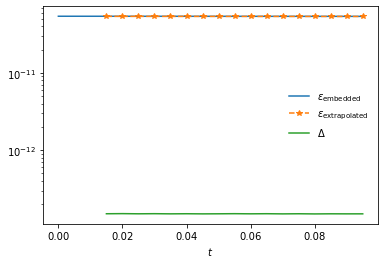

In [3]:
stats_serial = run(1, 20)
fig, ax = plt.subplots(1,1)
plot_hotrod(stats_serial, ax)
plt.show()

As we can see, the errors match up nicely and their difference is somewhat smaller. Massive success! Now what happens if we go PinT?

## Going PinT with Block Gauss-Seidel
### Extrapolation Error
One weakness of the extrapolation estimate is the memory overhead. But wait a minute! In block Gauss-Seidel, we are computing multiple steps at the same time, which need to be in memory anyways, so let's use that! The simplest thing we can do, is use one more process than we need steps to store from such that we compute the extrapolated error only on the last step and use all earlier steps for the extrapolation. Let's not worry about the effects of PinT for now.

### Embedded Error
Let's not do anything different for now and see what we get.

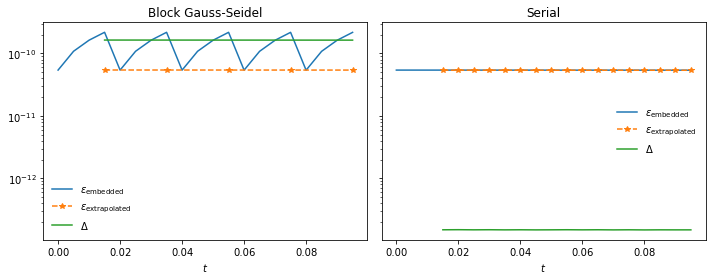

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par = run(4, 20)
plot_hotrod(stats_par, axs[0])
plot_hotrod(stats_serial, axs[1])
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

As you can see, the extrapolation error estimate is now spaced further appart, since we only compute it on every fourth step, but it didn't really change from the serial solution, which is weird! Smells like fish!
The embedded estimate on the other hand, is growing from step to step within the block, which is extremely reasonable, I think! What we end up with is two totally different error estimates and taking their difference is no use to detecting errors.

If you look closely, though, you see that the embedded error estimate is incremented by itself between steps. Let me plot what I mean:

In [5]:
def plot_hotrod_embedded_weirdness(stats, ax, size):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    e_em_fix = e_em / (np.arange(len(e_em))%size+1)
    
    ax.plot(t, e_em_fix, label=r'$\epsilon_\mathrm{embedded}$ fix', linestyle='-')
    ax.plot(t[ready], abs(e_em_fix[ready]-e_ex[ready]), label=r'$\Delta$ fix')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')
    ax.set_yscale('log')

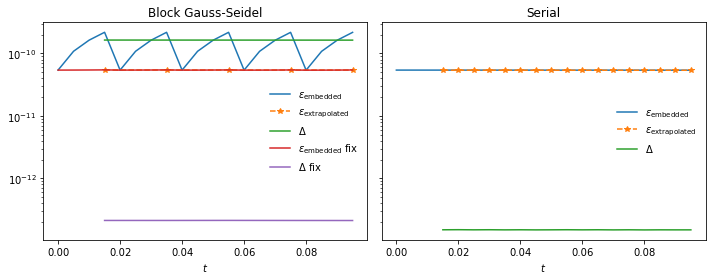

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
plot_hotrod(stats_par, axs[0])
plot_hotrod(stats_serial, axs[1])
plot_hotrod_embedded_weirdness(stats_par, axs[0], 4)
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

Look at the new lines labelled fix in the left plot. In the eye norm we fixed all our problems, and the difference is only slightly larger. Let's take a closer look:

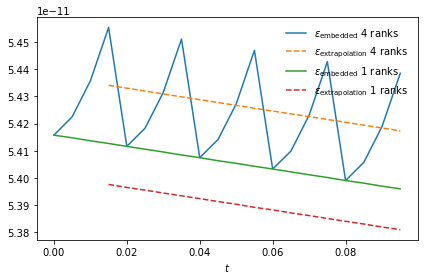

In [7]:
fig, ax = plt.subplots(1, 1)
def plot_hotrod_comp(stats, ax, size):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    e_em_fix = e_em / (np.arange(len(e_em))%size+1)
    
    ax.plot(t, e_em_fix, label=r'$\epsilon_\mathrm{embedded}$'+f' {size} ranks', linestyle='-')
    ax.plot(t[ready], e_ex[ready], label=r'$\epsilon_\mathrm{extrapolation}$'+f' {size} ranks', linestyle='--')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')

plot_hotrod_comp(stats_par, ax, 4)
plot_hotrod_comp(stats_serial, ax, 1)
fig.tight_layout()
plt.show()

This is now a comparison of just the error estimates in a linear scale. As you can see, going PinT changed the extrapolation error by remarkably little, while we still get some increment between steps with the embedded estimate, but it's really small compared to the overall error.
My feeling is that this is too easy! What did I miss? Why would this work? These questions that call for someone who acutally knows what's going on, like Thibaut!

Please note that I made the same test with the Piline equation, which is still linear, but a bit more interesting and found the same result: Dividing the embedded error by the rank + 1 brings it very close to the extrapolated error and both are very close to the time-serial result.

## Increasing the Block Size
Let's try something different then. We can increase the block size and then estimate the extrapolation error on every step after some start-up phase. See the results below for a block size of 100:

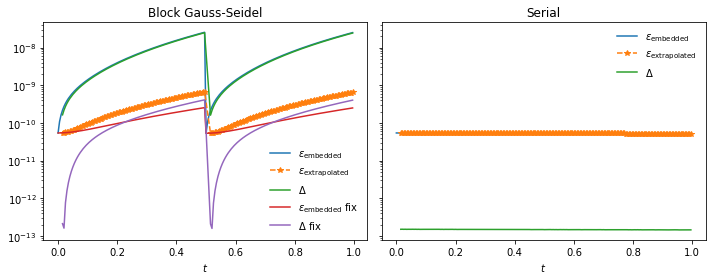

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par_big_block = run(100, 200)
stats_ser_big_block = run(1, 200)
plot_hotrod(stats_par_big_block, axs[0])
plot_hotrod(stats_ser_big_block, axs[1])
plot_hotrod_embedded_weirdness(stats_par_big_block, axs[0], 100)
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

As you can see, the error estimates increase from step to step within the block, which is very reasonable.
However, they increase at very different rates and the "fix" is not sufficient anymore. 

## LU-Preconditioner
So far, we considered only the implicit Euler preconditioner, because we rely on knowing the order of the scheme. But what the hell, right? Let's try LU!

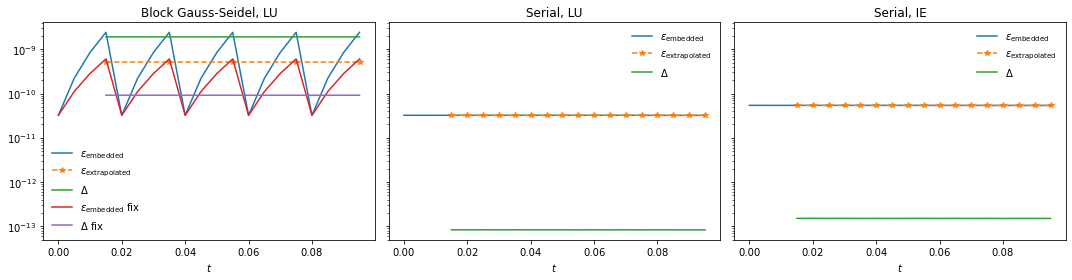

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 4))
stats_par_LU = run(4, 20, precon='LU')
stats_ser_LU = run(1, 20, precon='LU')
plot_hotrod(stats_par_LU, axs[0])
plot_hotrod(stats_ser_LU, axs[1])
plot_hotrod(stats_serial, axs[2])
plot_hotrod_embedded_weirdness(stats_par_LU, axs[0], 4)
axs[0].set_title('Block Gauss-Seidel, LU')
axs[1].set_title('Serial, LU')
axs[2].set_title('Serial, IE')
fig.tight_layout()
plt.show()

Whoopsidoodles! Hot Rod still works in serial, which is kind of surprising, maybe. In tests I did with my own code a while back, the order was the same between the two preconditioners when solving advection, so this makes sense. But it's all messed up in parallel! The extrapolated error is now larger. Why? And the fix does not work anymore, even though it brings the error estimates much closer together. I am really struggling to interpret this..

## Non-Linear Test
Let's try the same with Van-der-Pol

In [10]:
from pySDC.implementations.problem_classes.Van_der_Pol_implicit import vanderpol

def run_vdp(num_procs, num_steps):
    """
    A simple test program to do PFASST runs for the heat equation
    """

    # initialize level parameters
    level_params = dict()
    level_params['dt'] = 4e-2

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['collocation_class'] = CollGaussRadau_Right
    sweeper_params['num_nodes'] = 3
    sweeper_params['QI'] = 'IE'  # For the IMEX sweeper, the LU-trick can be activated for the implicit part

    problem_params = {           
        'mu'            :   5.,         
        'newton_tol'    :   1e-9,
        'newton_maxiter':   99,
        'u0'            :   np.array([2.0, 0.]),
    }

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 4

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = log_data
    controller_params['use_HotRod'] = True
    controller_params['HotRod_tol'] = 10
    controller_params['use_adaptivity'] = False
    controller_params['mssdc_jac'] = False

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = vanderpol  # pass problem class
    description['problem_params'] = problem_params  # pass problem parameters
    description['sweeper_class'] = generic_implicit  # pass sweeper
    description['sweeper_params'] = sweeper_params  # pass sweeper parameters
    description['level_params'] = level_params  # pass level parameters
    description['step_params'] = step_params

    # set time parameters
    t0 = 0.0
    Tend = 10#num_steps*level_params['dt']

    # instantiate controller
    controller_class = controller_nonMPI
    controller = controller_class(num_procs=num_procs, controller_params=controller_params,
                                   description=description)

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)
    
    return stats

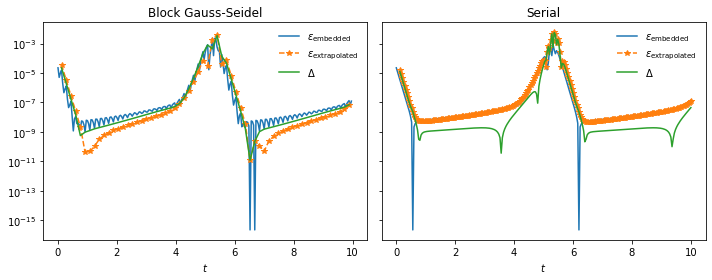

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par_vdp = run_vdp(4, 50)
stats_ser_vdp = run_vdp(1, 50)
plot_hotrod(stats_par_vdp, axs[0])
plot_hotrod(stats_ser_vdp, axs[1])
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

We start with just enough processes for the extrapolated estimate. First of all, the computation of the prefactor that is based on error accumulation is only really valid for linear equations, so when the step size is too large, we compute nonsense and indeed Hot Rod doesn't work in the the beginning in the serial case! If we decrease the step size, we can fix that, but then the step is so small that the change between sweeps is negligible and the embedded error estimate doesn't work anymore (I mean, this would mean a fixed point is reached and hence SDC has converged to the exact solution so indeed we get a zero local error, buuuuuuut we can't forget about the collocation error, so the embedded error estimate does not estimate the dominant error). So for fixed step size, there is no chance of really using Hot Rod here. 

Anyways, the effects of PinT are an offset in the extrapolation error, but again, the computation of the prefactor is messed up anyways... The embedded error shows the same saw tooth behaviour as earlier. Let's apply our simple fix:

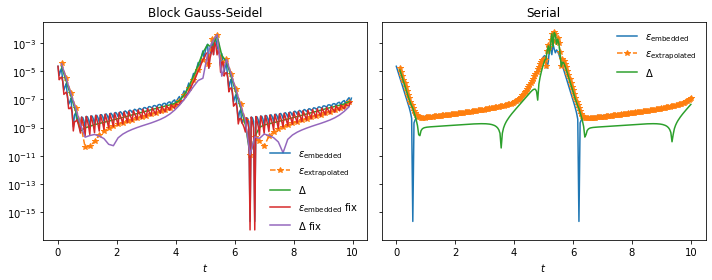

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par_vdp = run_vdp(4, 50)
stats_ser_vdp = run_vdp(1, 50)
plot_hotrod(stats_par_vdp, axs[0])
plot_hotrod(stats_ser_vdp, axs[1])
plot_hotrod_embedded_weirdness(stats_par_vdp, axs[0], 4)
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

Dammit! It appears the fix does not work for non-linear equations! The teeth of the saw get smaller amplitudes, (if this is a sensible statement...) but they remain in sufficient magnitude. Still: the error estimates are closer together.

Just for shits and giggles, we can also try with a huge block:

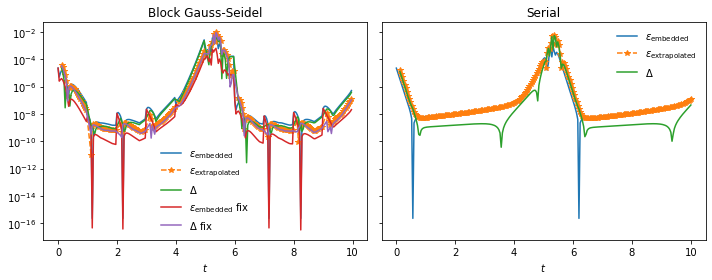

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par_vdp = run_vdp(25, 50)
stats_ser_vdp = run_vdp(1, 50)
plot_hotrod(stats_par_vdp, axs[0])
plot_hotrod(stats_ser_vdp, axs[1])
plot_hotrod_embedded_weirdness(stats_par_vdp, axs[0], 25)
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

Well, you know, it looks all weird, but that was to be expected...

# Summary
I keep thinking about the idea behind computing the prefactor for the extrapolation estimate: Each step picks up the local error of the last step as an error to its initial conditions and hence its error is the sum of all previous local errors. Now, I don't think this reasoning applies to the local error in block-GS SDC, but maybe we can think of a reason why something like this would be the case. 

Now if we increase the block size the local error is larger than just the sum of the serial local errors of previous steps (in the embedded estimate), which may mean that the whole idea is wrong. I am not sure how to interpret this.

I am really struggling with the preconditioners, also. When the order remains the same as with IE, it makes sense that the embedded estimate still works and the extrapolated estimate does not really depend on the order as long as the Taylor order is high enough, so we would expect it to work in serial. Also that the errors are slightly lower in serial is fine because LU is supposed to be a better preconditioner. But why is the error now larger in the PinT case? I can not make sense of this.

That the fix falls apart for non-linear equations does not mean the hypothesis is wrong, but it means we might be in trouble when it comes to implementing something useful for non-linear equations. However, I am quite happy about realising that the extrapolated estimate is simply not valid for non-linear equations. This is a major weakness of the Hot Rod detector, that I was unaware of! The solution might be to do adaptivity, such that the non-linearity does not impact us too much and we don't estimate zero error with the embedded method.

# Solution?
I am thinking that with the embedded method, what we are actually estimating is not the local error, but some kind of global error: In time serial we are waiting for k sweeps and then start the next step, but in Block GS, what we are actually doing is solving the block with a first order method, then with a second order method, and so on. This means the second to last sweep carries the result of an entirely $k-1$ method and the last sweep carries the result of an entirely order $k$ method. When subtracting the two, do I not get something like the global error of the order $k-1$ method within the block?